In [1]:
names = open("names.txt","r").read().splitlines()
names[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
len(names) , min(len(w) for w in names) , max(len(w) for w in names)

(32033, 2, 15)

In [4]:
chars = sorted(set("".join(names)))
chars,len(chars)
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [5]:
import torch
N = torch.zeros((27,27),dtype=torch.int32)

In [6]:
b = {}
for w in names:
    ch = ["."] + list(w) + ["."]
    for ch1,ch2 in zip(ch,ch[2:]):
       ix1 = stoi[ch1]
       ix2 = stoi[ch2]
       N[ix1, ix2] += 1

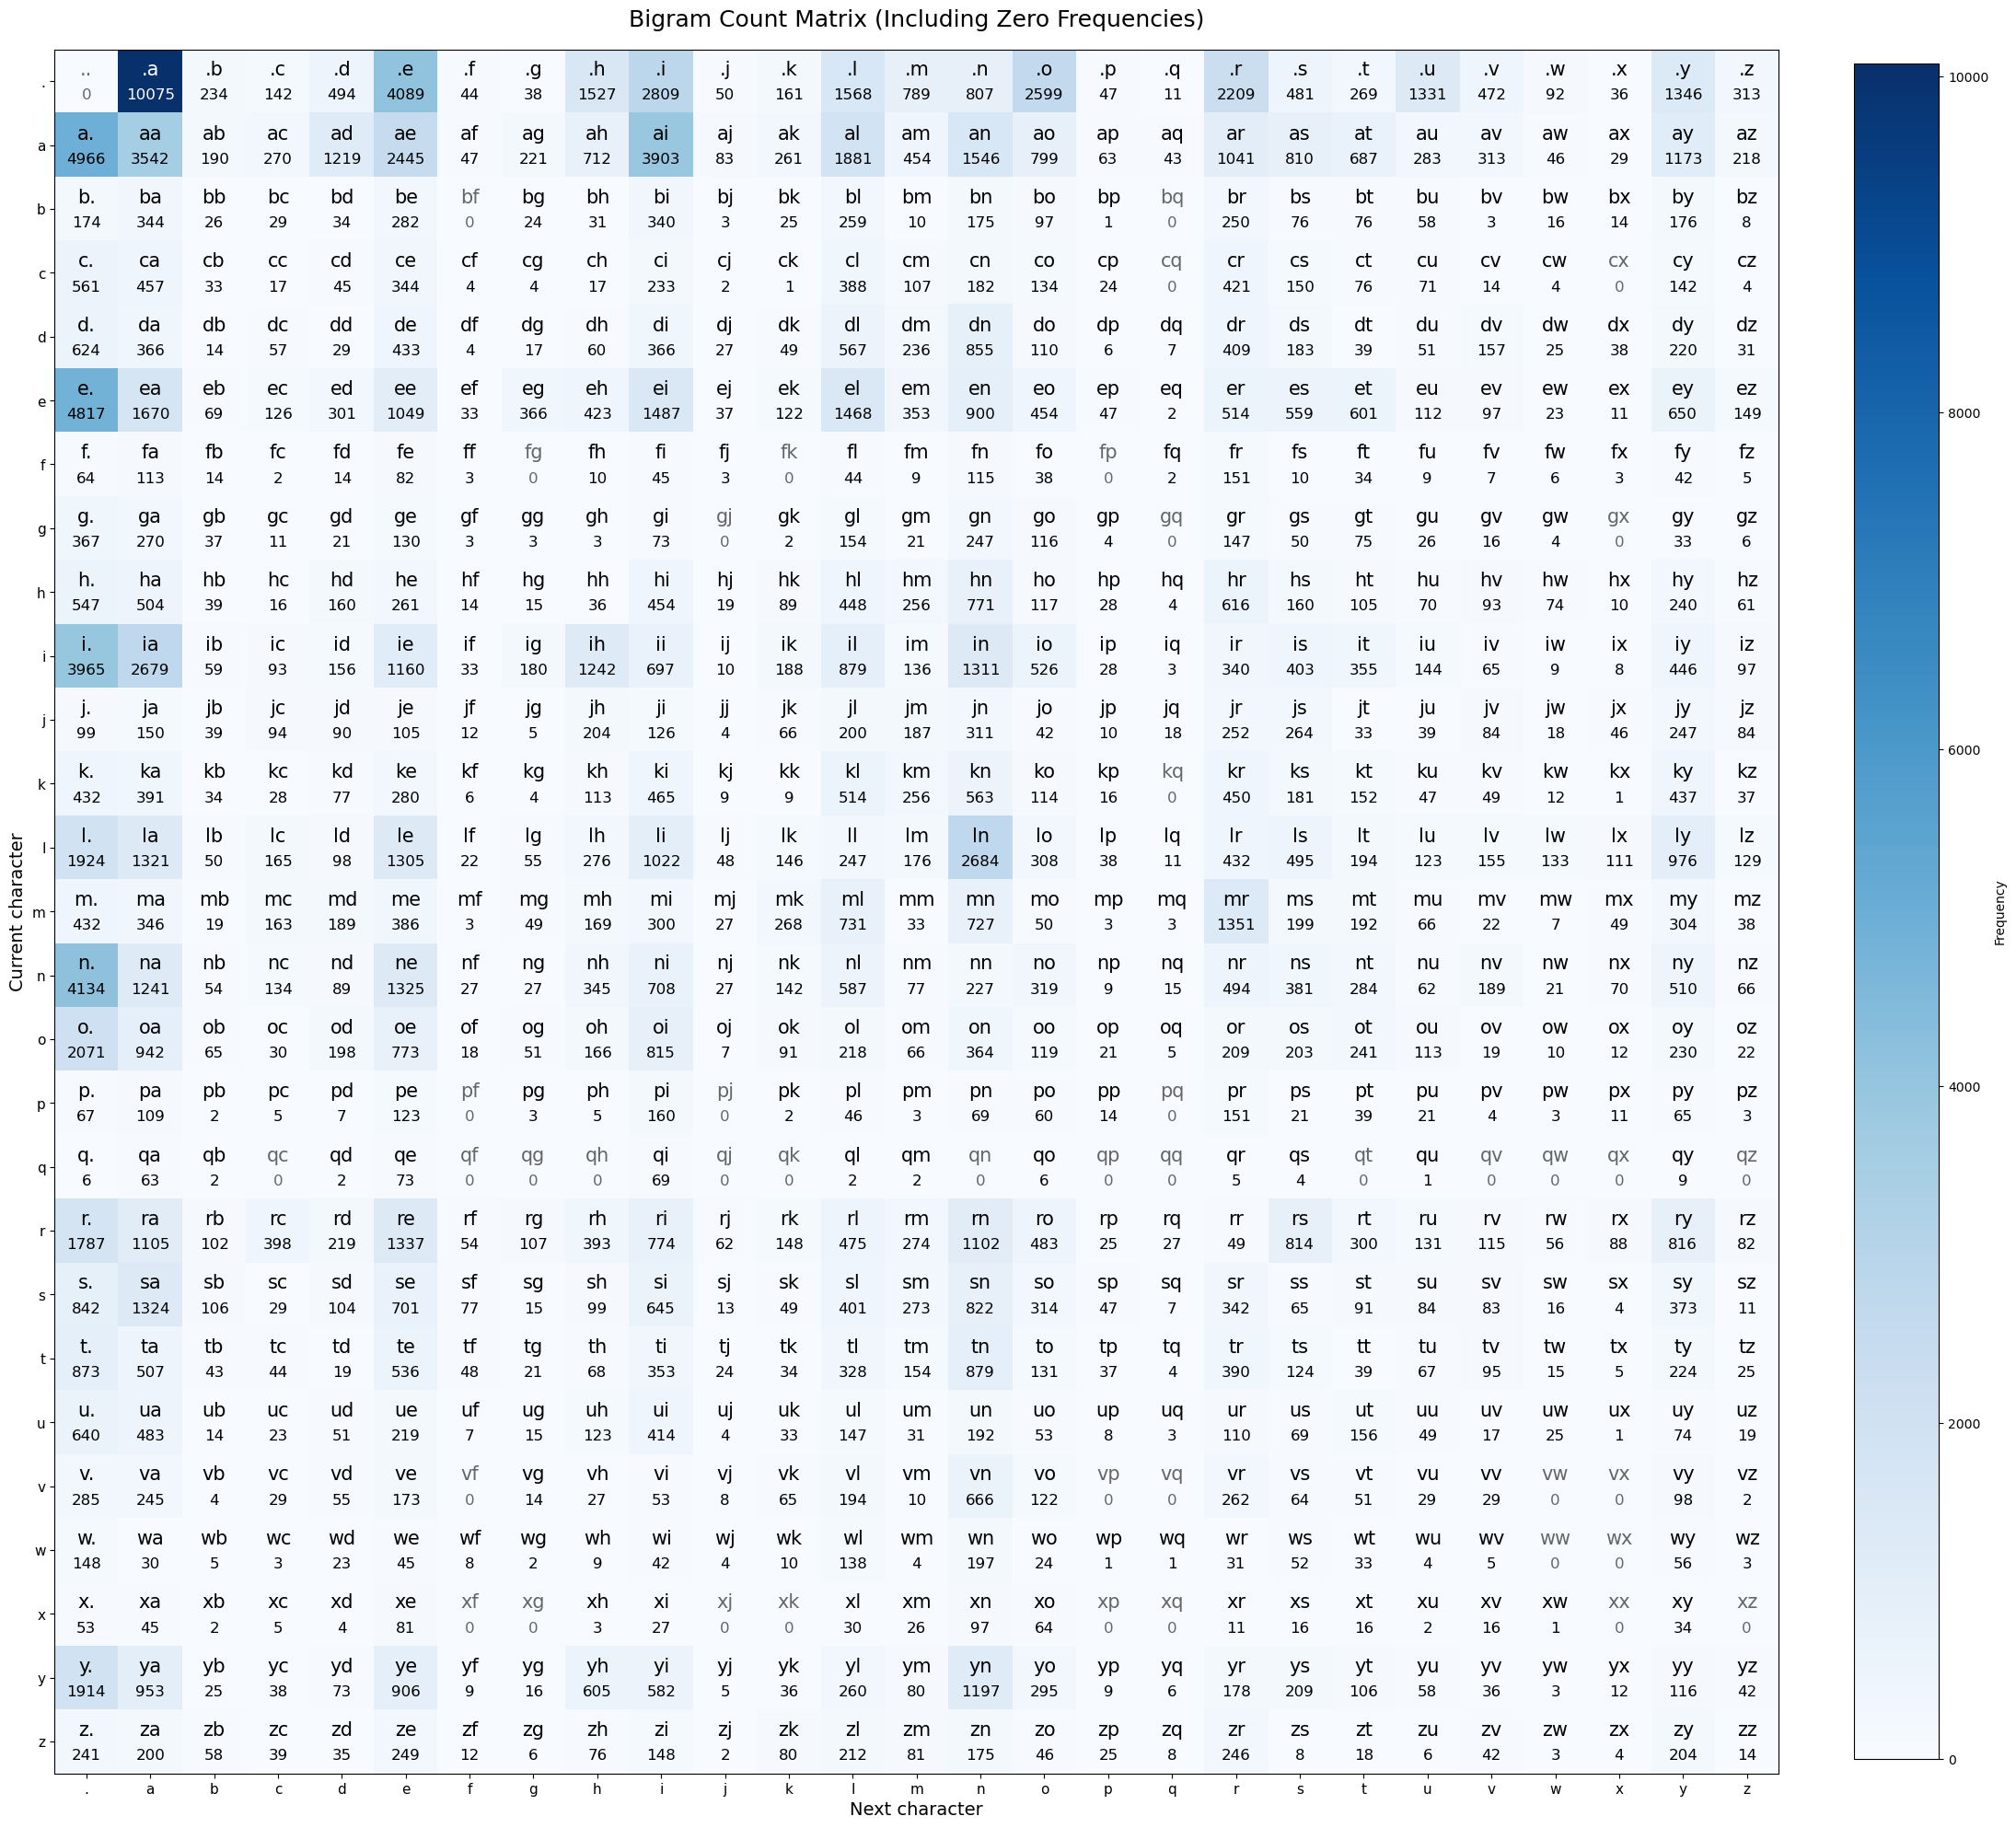

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch

# Ensure CPU + NumPy
M = N.detach().cpu().numpy() if torch.is_tensor(N) else np.array(N)

plt.figure(figsize=(22, 22))
plt.imshow(M, cmap='Blues', interpolation='nearest')

max_val = M.max()

for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        val = int(M[i, j])
        ch = itos[i] + itos[j]

        # Color logic:
        # - white text for high values
        # - dark grey for zero
        # - black otherwise
        if val == 0:
            color = "#666666"
        elif val > 0.6 * max_val:
            color = "white"
        else:
            color = "black"

        # Bigram label (top)
        plt.text(
            j, i - 0.18, ch,
            ha="center", va="center",
            fontsize=15, color=color
        )

        # Frequency value (bottom)
        plt.text(
            j, i + 0.22, val,
            ha="center", va="center",
            fontsize=12, color=color
        )

# Axis labels
plt.xticks(range(27), [itos[i] for i in range(27)], fontsize=11)
plt.yticks(range(27), [itos[i] for i in range(27)], fontsize=11)

plt.xlabel("Next character", fontsize=14)
plt.ylabel("Current character", fontsize=14)
plt.title("Bigram Count Matrix (Including Zero Frequencies)", fontsize=18, pad=18)

plt.colorbar(label="Frequency", fraction=0.045, pad=0.04)
plt.tight_layout()
plt.show()


In [8]:
N[0]

tensor([    0, 10075,   234,   142,   494,  4089,    44,    38,  1527,  2809,
           50,   161,  1568,   789,   807,  2599,    47,    11,  2209,   481,
          269,  1331,   472,    92,    36,  1346,   313], dtype=torch.int32)

In [9]:
p = N[0].float()
p = p / p.sum()
p
g = torch.Generator().manual_seed(420465445)
ix = torch.multinomial(p,num_samples=1, replacement=True ,generator=g).item()
itos[ix]

'a'

In [10]:
g = torch.Generator().manual_seed(1343)
p = torch.rand(3,generator=g)
p = p / p.sum()
p

tensor([0.1162, 0.3261, 0.5577])

In [11]:
torch.multinomial(p, num_samples=10,replacement=True,  generator=g)

tensor([1, 0, 2, 2, 2, 2, 2, 1, 2, 2])

In [12]:
P = (N+1).float()   #added +1 to avoid infinity value while log ing
# for i in range(27):
#     P[i] = P[i] / P[i].sum()
P /= P.sum(1,keepdim= True) 
P[3]

tensor([0.1623, 0.1323, 0.0098, 0.0052, 0.0133, 0.0997, 0.0014, 0.0014, 0.0052,
        0.0676, 0.0009, 0.0006, 0.1124, 0.0312, 0.0529, 0.0390, 0.0072, 0.0003,
        0.1219, 0.0436, 0.0222, 0.0208, 0.0043, 0.0014, 0.0003, 0.0413, 0.0014])

In [13]:
g = torch.Generator().manual_seed(2345457)

ix = 0
out = []
for _ in range(5):
    while True:
        p = N[ix].float()
        p = p / p.sum()
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        sx = itos[ix]
       
        out.append(sx)
        name = "".join(out)
        if ix == 0:
            break
    
    print(name)
    out = []

obaoaynvlavaa.
tesaa.
ad.
elsia.
ai.


In [727]:
log_likli = 0
n = 0
for w in names:
    ch = ["."] + list(w) + ["."]
    for ch1,ch2 in zip(ch,ch[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        log_prob = torch.log(prob).item()
        log_likli += log_prob
        # print(f'{ch1}{ch2} | {prob=:.4f} | {log_prob= :.4f}')
        n += 1
 
nll = -log_likli
avg_nll = nll / n
print(log_likli)    
print(nll)    
print(avg_nll)

-691042.9441606998
691042.9441606998
3.028950514848824


In [530]:
#training 
xs, ys =[], []

for w in names:
    chs = "." + w + "."
    for ch1,ch2 in zip(chs,chs[1:]):
        
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

len(ys)

228146

In [532]:
xs = torch.tensor(xs).long()
ys = torch.tensor(ys).long()
xs,ys

(tensor([ 0,  5, 13,  ..., 25, 26, 24]),
 tensor([ 5, 13, 13,  ..., 26, 24,  0]))

In [534]:
import torch.nn.functional as F


In [536]:

W = torch.randn((27,27), generator =g, requires_grad=True)

In [502]:
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
probs[0]
probs[torch.arange(5), ys] #plucks out the probs of ys corresponding to xs

tensor([0.8010, 0.6593, 0.4121, 0.3993, 0.7846], grad_fn=<IndexBackward0>)

In [504]:
loss = -probs[torch.arange(5), ys].log().mean()
loss

tensor(0.5371, grad_fn=<NegBackward0>)

In [506]:
#backward pass
W.grad = None
loss.backward()

In [508]:
#update
W.data += -0.8 * W.grad

In [723]:
#refreshing my memory
for i in range(500):

    #forward pass
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp() # equalent to N
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(len(xs)),ys].log().mean()

    if i %100 == 0:
        print(loss)
    

    W.grad = None
    loss.backward()

    W.data += -100 * W.grad


tensor(2.4820, grad_fn=<NegBackward0>)
tensor(2.4820, grad_fn=<NegBackward0>)
tensor(2.4820, grad_fn=<NegBackward0>)
tensor(2.4820, grad_fn=<NegBackward0>)
tensor(2.4820, grad_fn=<NegBackward0>)


In [556]:
len(xs)

228146

In [721]:
g = torch.Generator().manual_seed(42)

for _ in range(10):
    ix = 0
    out = []
    while True:
        cxen = F.one_hot(torch.tensor([ix]),num_classes = 27).float()
        logits = cxen @ W
        counts = logits.exp()
        p = counts / counts.sum(1,keepdims=True)
        ix = torch.multinomial(p, num_samples=1,replacement=True,generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print("".join(out))

a.
feeenvi.
s.
ma.
iaushan.
sta.
millaylela.
josh.
li.
le.
